## Rejection Option-based Classification

### Table of contents :
1. [Introduction](#1.-Introduction)
2. [Data preparation](#2.-Data-preparation)
3. [Train classifier network](#3.-Train-classifier-network)
	* [Model fairness](#Model-fairness) 
4. [Mitigate the bias using ROC](#4.-Mitigate-the-bias-using-ROC)
	* [Estimate optimal parameters for the ROC method](#Estimate-optimal-parameters-for-the-ROC-method)
	* [Model Fairness after bias mitigation](#Model-Fairness-after-bias-mitigation)
5. [Summary](#5.-Summary)
6. [References](#6.-References)



## 1. Introduction
Welcome!

We hope you have had a chance to go through the previous Sony fairness tutorials. In those tutorials, we had touched upon pre-processing & in-processing techniques for bias mitigation. We also showed how to compute model fairness using different fairness criteria.

In this tutorial, we give an overview of a post-processing technique for bias mitigation in predictive models.

Post-processing algorithms are mitigation steps that can be applied to the model predictions. [Decision Theory for Discrimination-Aware Classification](#https://ieeexplore.ieee.org/document/6413831), [Equality of Opportunity in Supervised Learning](#https://papers.nips.cc/paper/2016/file/9d2682367c3935defcb1f9e247a97c0d-Paper.pdf), and [Classification with Fairness Constraints](#https://papers.nips.cc/paper/2017/file/b8b9c74ac526fffbeb2d39ab038d1cd7-Paper.pdf) are among the different post-processing bias mitigation techniques currently proposed from academic literature. 

In this tutorial, we will focus on exploring decision theory for discrimination-aware classification technique called Reject Option-based Classification (ROC) see how to mitigate the bias in a predictive model.

Before we go into detailed explanation, here is a sneak peek into the steps involved in the process:


In [1]:
# Preparation
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/rejection_option_based_classification

import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/roc_workflow_diagram.png')
cv2_imshow(img)

As illustrated in the picture, we will train a classifier ML model, analyze model fairness and then show how ROC technique  reduces the bias in model predictions.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from warnings import warn
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from utils import *

## 2. Data preparation

Before training a model, we need to parse dataset and divide it into three categories i.e: features, targets and sensitive attributes. `features` contain input attributes, `targets` contain binary class labels (income range) and `sensitive attributes` contain attributes for which we want the prediction to be fair (race, sex, etc.).

In [3]:
X, y, Z = load_adult_data()

features : 28750 samples, 88 attributes

targets : 28750 samples

sensitives attributes : 28750 samples, 2 attributes

sensitives attributes names : ['race', 'sex'] 

#### Splitting Data into Training ,Testing and Validation Sets

Split the data (features,targets,sensitives attributes) into train, test and validation data sets.

In [4]:
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val, Z_train, Z_val = train_test_split(X_train, y_train, Z_train, test_size=0.15, random_state=1)

#standardize the data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(X_train)
X_test = scale_orig.fit_transform(X_test)
X_val = scale_orig.fit_transform(X_val)

## 3. Train classifier network
Train classifier on original training data and predict the class for test data instances using our finalized classification model.

In [5]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
preds_baseline = model.predict(X_test)

#### Predict probabilities on the Val & Test Dataset
Let's Obtain the scores of validation and test sets. This is useful generally as it provides a measure of the certainty or uncertainty of a prediction.

In [6]:
# positive class index
pos_ind = np.where(model.classes_ == 1)[0][0]
val_score = model.predict_proba(X_val)[:,pos_ind]
test_score = model.predict_proba(X_test)[:,pos_ind]

#### Best classification threshold for classification 

Let's estimate the optimal classification threshold that maximizes balanced accuracy without fairness constraints.

In [7]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
classification_thershold_array = np.linspace(0.01, 0.99, num_thresh)
for idx, classification_thershold in enumerate(classification_thershold_array):
    y_val_pred = np.where(val_score > classification_thershold, 1, 0)
    val_acc = metrics.accuracy_score(y_val, y_val_pred)
    ba_arr[idx] = val_acc
best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_classification_thershold = classification_thershold_array[best_ind]

print("Best balanced accuracy  = %.4f" % np.max(ba_arr))
print("Optimal classification threshold = %.4f" % best_classification_thershold)

Best balanced accuracy  = 0.8464
Optimal classification threshold = 0.4357


### Model fairness 

Let's start our investigation classifier model fairness by analyzing the test and validation prediction scores, depending on the optimal classification threshold. In the previous tutorial (three metric tutorial link goes here), we've shown how to measure model fairness using different fairness criteria (Demographic parity, Equal opportunity & Equalized odds).

Get model fairness with respect to sensitive attribute.

#### Model Fairness on validation set 

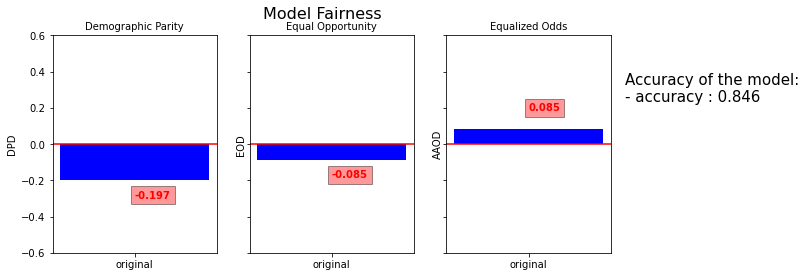

In [8]:
sensitive_attribute = 'sex' # you can chose the sensitive_attribute, wich to know the fairness
y_val_pred = np.where(val_score > best_classification_thershold, 1, 0)
DPD,EOD,AAOD = get_fairness(y_val, Z_val[sensitive_attribute] == 1, y_val_pred)
accuracy = metrics.accuracy_score(y_val, y_val_pred)
plot_fairness_multi(DPD, EOD, AAOD, accuracy, bar_x_axis="original")

#### Model Fairness on Test set

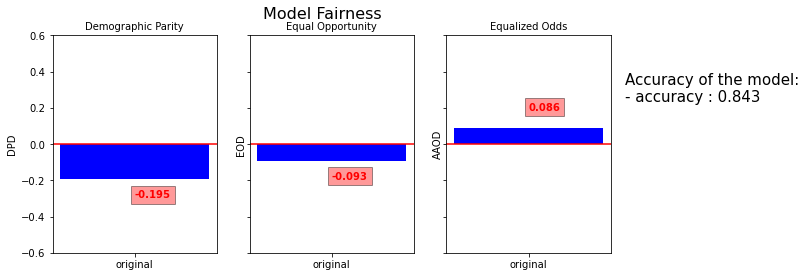

In [9]:
y_test_pred = np.where(test_score > best_classification_thershold, 1, 0)
DPD,EOD,AAOD = get_fairness(y_test, Z_test[sensitive_attribute] == 1, y_test_pred)
accuracy = metrics.accuracy_score(y_test, y_test_pred)
plot_fairness_multi(DPD, EOD, AAOD, accuracy, bar_x_axis="original")

As seen in the above plots, predictions are definitely not fair when considered in the context of the sensitive attribute. So we need to mitigate the bias.

In general, we can mitigate the bias in three ways such as pre-processing, in-processing, and postprocessing. In previous tutorials we have discussed pre-processing and in-processing techniques to mitigate the bias in the data set and the model. In this tutorial we will employ a  post-processing technique to mitigate the bias at prediction time.

Post-processing algorithms are mitigation steps that can be applied to the model predictions. In this tutorial, we will focus on a simple and generic post-processing technique called Reject Option-based Classification (ROC).

## 4. Mitigate the bias using ROC
In this approach, the assumption is that most discrimination occurs when a model is least certain of the prediction i.e. around the decision boundary (classification threshold). For example, with a classification threshold of 0.5, if the model prediction is 0.81 or 0.1, we would consider the model certain of its prediction but for 0.51 or 0.49, the model is not certain about the chosen category. In ROC, for model predictions with the highest uncertainty around the decision boundary, when the favorable outcome is given to the privileged group or the unfavorable outcome is given to the unprivileged. So we will modify the model predictions by giving favorable outcomes to unprivileged groups and unfavorable outcomes to privileged groups in a confidence band around the decision boundary with highest uncertainty.

### Estimate optimal parameters for the ROC method

Please look at code below to estimate optimal parameters (optimal classification threshold and critical region boundary (ROC margin)) for desired constraint on fairness using ROC technique. 
 
Constraints can be used on following fairness measures:
* Statistical parity difference 
* Absolute Average odds difference
* Equal opportunity difference 
 
Best parameters are those that maximize the classification threshold while satisfying the fairness constraints.

In [1]:
def reject_option_classification(y_true, y_predicted_score,privileged_group,
                metric_name="Statistical parity difference"):
    
    """ 
    Reject option classification is a postprocessing technique that swaps outcomes 
    between privileged and underprivileged groups near the decision boundary.
    
    Args:
        y_true: ground truth (correct) target values.
        y_predicted_score: estimated probability predictions (targets score) as returned by a classifier.
        privileged_group: list of privileged group values.
        metric_name: name of the metric to use for the optimization(Statistical parity difference,
                     Absolute average odds difference,Equal opportunity difference)

    Returns:
        ROC_margin: critical region boundary,
        classification_threshold: optimal classification threshold
    
    """
   
    low_classification_threshold=0.01 # smallest classification threshold
    high_classification_threshold=0.99 # highest classification threshold
    number_classification_threshold=100 # number of classification threshold b/w low class threshold and high class threshold
    number_ROC_margin=50 # number of relevant ROC margins to be used in the optimization search
    metric_upper_bound=0.03 # upper bound of constraint on the metric value
    metric_lower_bound=-0.03 # lower bound of constraint on the metric value
    
    fair_metric_array = np.zeros(number_classification_threshold * number_ROC_margin)
    balanced_accuracy_array = np.zeros_like(fair_metric_array)
    ROC_margin_array = np.zeros_like(fair_metric_array)
    classification_threshold_array = np.zeros_like(fair_metric_array)

    count = 0
    # Iterate through class thresholds
    for class_thresh in np.linspace(low_classification_threshold,
                                    high_classification_threshold,
                                    number_classification_threshold):

        classification_threshold = class_thresh
        if class_thresh <= 0.5:
            low_ROC_margin = 0.0
            high_ROC_margin = class_thresh
        else:
            low_ROC_margin = 0.0
            high_ROC_margin = (1.0-class_thresh)

        # Iterate through ROC margins
        for ROC_margin in np.linspace(
                            low_ROC_margin,
                            high_ROC_margin,
                            number_ROC_margin):
            ROC_margin = ROC_margin
            # Predict using the current threshold and margin
            y_pred = predict(y_predicted_score,classification_threshold,ROC_margin,privileged_group)
            acc = metrics.accuracy_score(y_true, y_pred)
            DPD,EOD,AAOD = get_fairness(y_true, privileged_group, y_pred)
            ROC_margin_array[count] = ROC_margin
            classification_threshold_array[count] = classification_threshold
            balanced_accuracy_array[count] = acc
            if metric_name == "Statistical parity difference":
                fair_metric_array[count] = DPD
            elif metric_name == "Absolute average odds difference":
                fair_metric_array[count] = AAOD
            elif metric_name == "Equal opportunity difference":
                fair_metric_array[count] = EOD
            count += 1

    rel_inds = np.logical_and(fair_metric_array >= metric_lower_bound,
                              fair_metric_array <= metric_upper_bound)
    if any(rel_inds):
        best_ind = np.where(balanced_accuracy_array[rel_inds]
                            == np.max(balanced_accuracy_array[rel_inds]))[0][0]
    else:
        warn("Unable to satisy fairness constraints")
        rel_inds = np.ones(len(fair_metric_array), dtype=bool)
        best_ind = np.where(fair_metric_array[rel_inds]
                            == np.min(fair_metric_array[rel_inds]))[0][0]

    ROC_margin = ROC_margin_array[rel_inds][best_ind]
    classification_threshold = classification_threshold_array[rel_inds][best_ind]

    return ROC_margin,classification_threshold


In [2]:
def predict(y_predicted_score,classification_threshold,ROC_margin,privileged_group):
    """
    Obtain fair predictions with ROC method
    
    Args:
        y_predicted_score: estimated probability predictions (targets score) as returned by a classifier.
        classification_threshold : otimal classification threshold
        ROC_margin : critical region boundary
        privileged_group : list of privileged group values.
    Returns:
        y_pred: predictions using ROC method       
    
    """

    y_pred = np.where(y_predicted_score > classification_threshold, 1, 0)

    # Indices of critical region around the classification boundary
    critical_region_indices = np.logical_and(
            y_predicted_score <= classification_threshold + ROC_margin,
            y_predicted_score > classification_threshold - ROC_margin)

    # Indices of privileged and unprivileged groups
    cond_priv =  privileged_group
    cond_unpriv = privileged_group==False
    y_pred[np.logical_and(critical_region_indices,
                        cond_priv)] = 0
    y_pred[np.logical_and(critical_region_indices,
                        cond_unpriv)] = 1

    return y_pred

So let's estimate the optimal classification threshold, and the critical region boundary (ROC margin) using a validation set for the desired constraint on fairness.

In this tutorial, we have used `Equal opportunity difference` as a fairness constraint.

In [12]:
# Metric used
metric_name = "Equal opportunity difference"
ROC_margin,classification_threshold = reject_option_classification(y_val,val_score,Z_val[sensitive_attribute] == 1,
                metric_name=metric_name)
print(ROC_margin,classification_threshold)

0.043648732220160795 0.3564646464646465


### Model Fairness after bias mitigation

#### Model Fairness on Val set
Let's obtain the prediction for validation data using estimated optimal classification threshold, compute accuracy and fairness metrics.

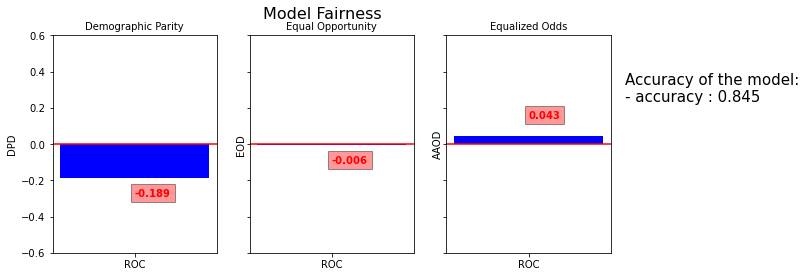

In [13]:
pred = predict(val_score,classification_threshold,ROC_margin,Z_val[sensitive_attribute] == 1)
accuracy = metrics.accuracy_score(y_val, pred)
DPD,EOD,AAOD = get_fairness(y_val,Z_val[sensitive_attribute] == 1, pred)
plot_fairness_multi(DPD, EOD, AAOD, accuracy, bar_x_axis="ROC")

#### Model Fairness on Test set
Let's obtain prediction for test data using estimated optimal classification threshold, compute accuracy and fairness metrics.

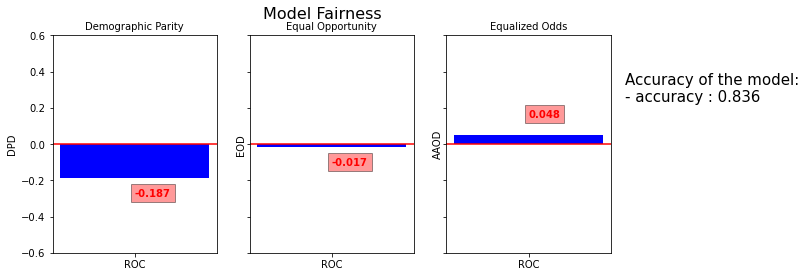

In [14]:
pred = predict(test_score,classification_threshold,ROC_margin,Z_test[sensitive_attribute] == 1)
accuracy = metrics.accuracy_score(y_test, pred)
DPD,EOD,AAOD = get_fairness(y_test,Z_test[sensitive_attribute] == 1, pred)
plot_fairness_multi(DPD, EOD, AAOD, accuracy, bar_x_axis="ROC")

As seen in the above plots, model accuracy dropped by 0.7, but with this technique was able to reduce the Absolute Average Odds Difference and Equal opportunity almost to zero. To achieve this reduction in bias, the decision-makers should consider the tradeoff between accuracy and fairness.

## 5. Summary

In this tutorial, we have shown how to reduce the bias at prediction time using a post-processing technique (Reject Option based Classification). In comparison to in-processing methods like Adversarial debiasing, experiments show that in-processing techniques are more effective at reducing bias than post-processing techniques such as ROC. However, advantage of this method is: ML practitioners could directly intervene at the last stage of the modeling workflow without modifying the data or learning algorithm while effectively reducing the bias with small drop in accuracy. 

## 6. References

1. [Decision theory for discrimination-aware classification](#https://ieeexplore.ieee.org/document/6413831)
2. [Equality of Opportunity in Supervised Learning](#https://papers.nips.cc/paper/2016/file/9d2682367c3935defcb1f9e247a97c0d-Paper.pdf)
3. [On Fairness and Calibration](#https://papers.nips.cc/paper/2017/file/b8b9c74ac526fffbeb2d39ab038d1cd7-Paper.pdf)
4. [Mitigating Unwanted Biases with Adversarial Learning](#https://arxiv.org/pdf/1801.07593.pdf)
5. [Adult — UCI Machine Learning](#http://archive.ics.uci.edu/ml/datasets/Adult)
6. [AI Fairness 360: An extensible toolkit for detecting and mitigating algorithmic bias](#https://arxiv.org/pdf/1810.01943.pdf)
